# Code to load, calculate and plot histograms of SCALE-RM Data
---

Choose the date, time and ensemble size. Previously used dates are 29.05.2016 12:00UTC and 01.06.2016 12:00UTC.

#### !!! Careful with ensemble size of 1000 members, a lot of free memory is necessary !!!

Calculated variables:
1. stab: Stability, calculated between the level above and below with log in denominator
2. stab1: Stability, calculated between the level above and below without log in denominator
3. stab2: Stability, calculated between 350hPa and 750hPa
4. prec: Precipitation, unit is mm/s !!!
5. prec_max: Maximum Precipitation of the whole ensemble at every point in domain
6. prec_prob: Precipitaion probability, definition of precipitation is 0.1mm/h
7. prec_prob_high/medi/low: Classification of precipitation probability

In [1]:
%matplotlib inline 

import matplotlib
from matplotlib import pyplot as plt

import sys, os, copy, scipy, math, getpass, subprocess, argparse, time, re, pdb, socket, warnings
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from enstools.io import read, write

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import dask

In [20]:
import warnings

## Load Data

In [21]:
# Load temperature data 'TH0020', 'TH0040', 'TH0200', 'TH1000'
# Load precipitation data 'EN0020', 'EN0040', 'EN0200', 'EN1000'
# 29.05.2016 12:00 and 01.06.2016 12:00 available (used forecast is 15:00 UTC)
# Change ens for different ensemble sizes. 20, 40, 200, 1000 Members available

dask.config.set(scheduler='processes')

day = '29'
month = '05'
time = '1200'
ens = '20'

date = month+day

#convert for the plots
if month == '05':
    m = 'Mai'
elif month == '06':
    m = 'Juni'
if time == '1200':
    t = '15:00'


if ens == '20':
    num = '0020'
    ensemble_TH = 'TH0020'
    ensemble_PR = 'EN0020'
elif ens == '40':
    num = '0040'
    ensemble_TH = 'TH0040'
    ensemble_PR = 'EN0040'
elif ens == '200':
    num = '0200'
    ensemble_TH = 'TH0200'
    ensemble_PR = 'EN0200'
elif ens == '1000':
    num = '1000'
    ensemble_TH = 'TH1000'
    ensemble_PR = 'EN1000'

path_TH = '/scratch/das/tnecker/kwork/run/'+ensemble_TH+'/2016'+month+day+time+'/'+num+'/member*.nc'
dataset_TH = read(path_TH, member_by_filename="member(.*?).nc", in_memory=False)

path_PR = '/scratch/das/tnecker/kwork/run/'+ensemble_PR+'/2016'+month+day+time+'/'+num+'/member*.nc'
dataset_PR= read(path_PR, member_by_filename="member(.*?).nc", in_memory=False)

warnings.filterwarnings("default")
warnings.filterwarnings("ignore")

/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/swd/manual/enstools/v2021.11/lib/python3.8/site-packages/xarray/

In [22]:
# Check datasets
dataset_TH , dataset_PR

(<xarray.Dataset>
 Dimensions:  (lat: 352, lev: 20, lon: 250, time: 6, ens: 20)
 Coordinates:
   * lat      (lat) float64 1.0 2.0 3.0 4.0 5.0 ... 348.0 349.0 350.0 351.0 352.0
   * lev      (lev) float64 975.0 950.0 925.0 900.0 ... 250.0 200.0 150.0 100.0
   * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 246.0 247.0 248.0 249.0 250.0
   * time     (time) datetime64[ns] 2016-05-29T12:00:00 ... 2016-05-29T17:00:00
   * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
 Data variables:
     theta    (time, ens, lev, lat, lon) float64 dask.array<chunksize=(6, 1, 20, 352, 250), meta=np.ndarray>
 Attributes:
     CDI:          Climate Data Interface version 1.9.4 (http://mpimet.mpg.de/...
     CDO:          Climate Data Operators version 1.9.4 (http://mpimet.mpg.de/...
     Conventions:  CF-1.6,
 <xarray.Dataset>
 Dimensions:     (time: 15, lon: 250, lat: 352, lev: 5, ens: 20)
 Coordinates:
   * time        (time) datetime64[ns] 2016-05-29T12:00:00 ... 2016-05-30T02:0

In [23]:
# Load domain coordinates (Cutoff at the edges due to unrealistic results)
lat2d=np.load('/scratch/das/tnecker/kwork/experiments/lat2d_high_resolution.npy')[7:345,12:243]
lon2d=np.load('/scratch/das/tnecker/kwork/experiments/lon2d_high_resolution.npy')[7:345,12:243]

## Calculations

### Stability

In [24]:
# Convert to np.array
theta_array = np.array(dataset_TH['theta'].isel(time=3,lat = np.arange(7,345,1),lon = np.arange(12,243,1)))

In [25]:
# Calculation of stability (Minus in the equation is convention for positive stability)
# Log in denominator
stab = np.zeros([len(dataset_TH.coords['ens'].values),len(dataset_TH.coords['lev'].values)-2,len(lat2d[::,0]),len(lon2d[0,::])])

for i in range(1,19,1):
    stab[::,i-1,::,::] = -(theta_array[::,i+1] - theta_array[::,i-1])/(np.log(dataset_TH.coords['lev'].values[i+1]) - np.log(dataset_TH.coords['lev'].values[i-1]))

In [26]:
# No log in denominator
stab1 = np.zeros([len(dataset_TH.coords['ens'].values),len(dataset_TH.coords['lev'].values)-2,len(lat2d[::,0]),len(lon2d[0,::])])

for i in range(1,19,1):
    stab1[::,i-1,::,::] = -(theta_array[::,i+1] - theta_array[::,i-1])/(dataset_TH.coords['lev'].values[i+1] - dataset_TH.coords['lev'].values[i-1])

In [27]:
# stability calculated between 350hPa and 750hPa
stab2 = -(theta_array[::,6] - theta_array[::,14])/(np.log(dataset_TH.coords['lev'].values[6]) - np.log(dataset_TH.coords['lev'].values[14]))

### Precipitation

In [28]:
# Convert to np.array
prec = np.array(dataset_PR['prec'].isel(time=3,lat = np.arange(7,345,1),lon = np.arange(12,243,1)))

In [29]:
# Calculations of maximum precipitaion, probability and the classification
prec_max = np.max(prec,axis=0,keepdims=False)

prec_def = np.where(prec>=0.1/3600,1,0)
prec_prob = np.mean(prec_def,axis=0)

prec_prob_high = np.where(prec_prob>=0.90,3,0)
prec_prob_medi = np.where((prec_prob<0.90) & (prec_prob>0.1),2,0)
prec_prob_low = np.where(prec_prob<=0.1,1,0)

## Plotting Temperature

(array([280., 300., 320., 340., 360., 380., 400., 420., 440.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

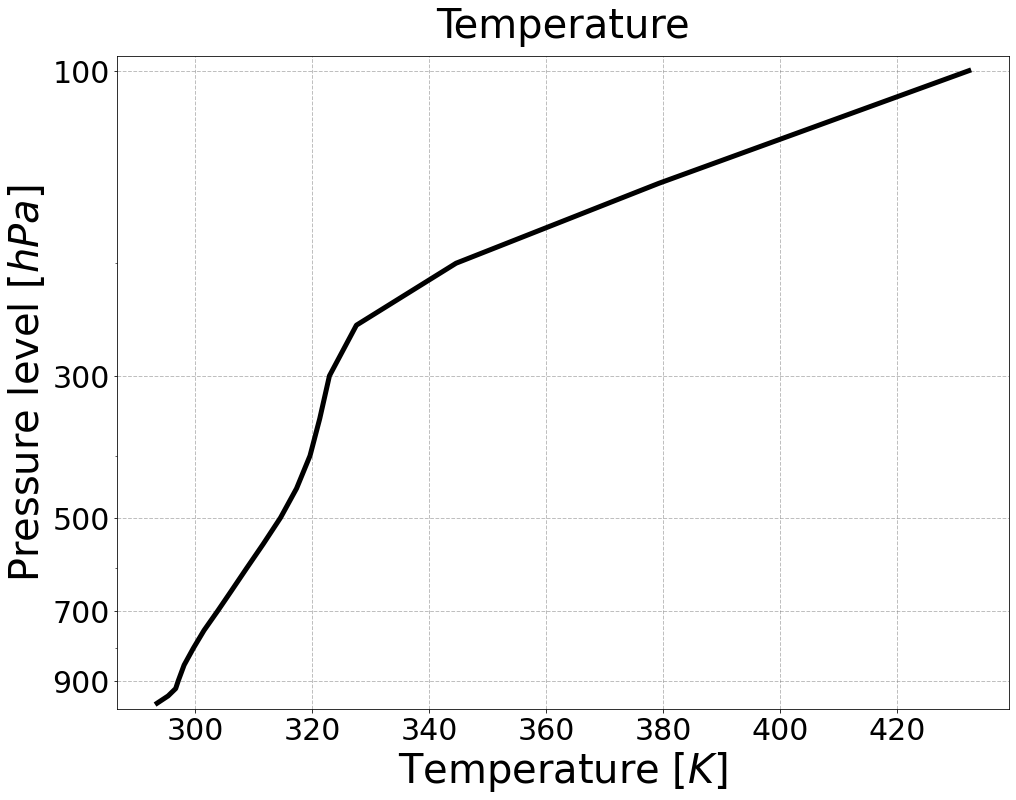

In [31]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(theta_array,(0,2,3)),dataset_TH.coords['lev'].values[0:20], linewidth = 5,c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('Temperature', size =40,y=1.02)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Temperature [$K$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
# plt.xlim(-0.05e-5,2.1e-5)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/theta_vert_'+ens+'mem_2016'+date+'1500.png')

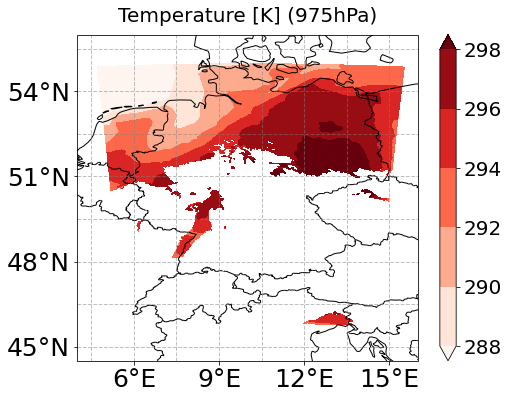

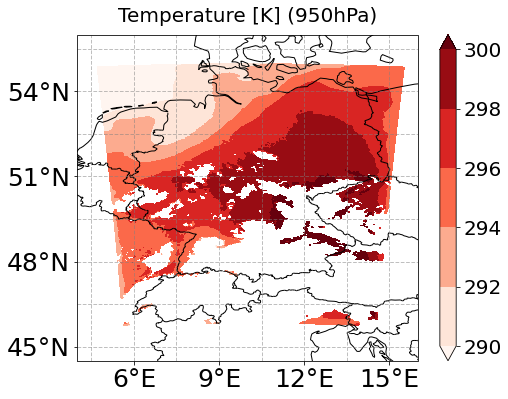

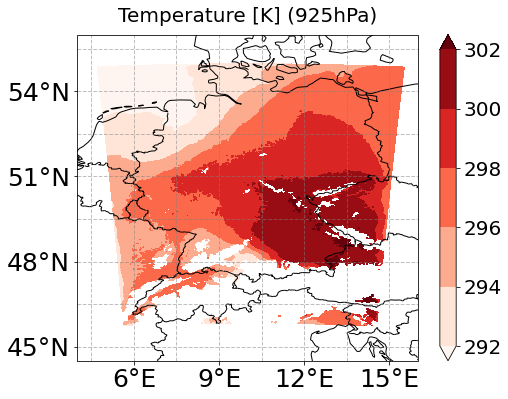

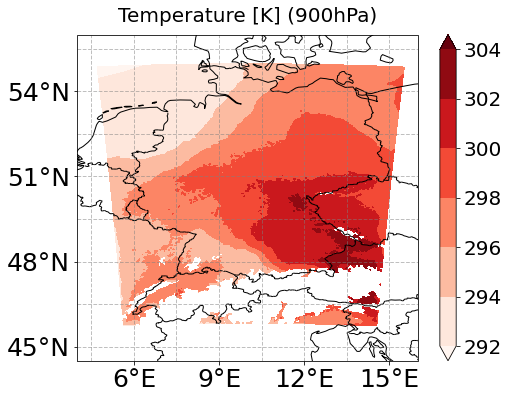

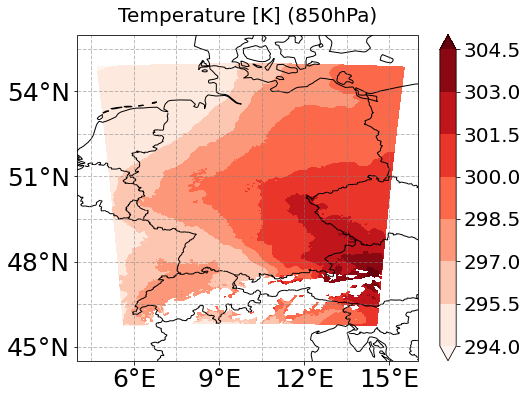

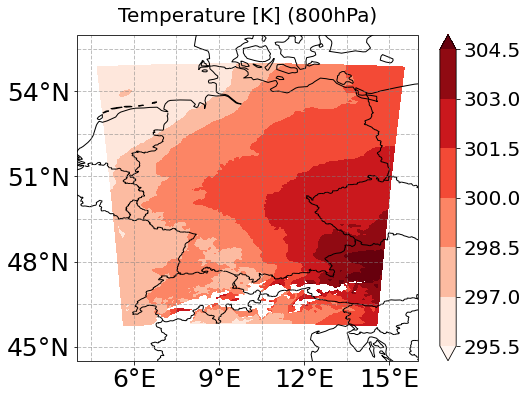

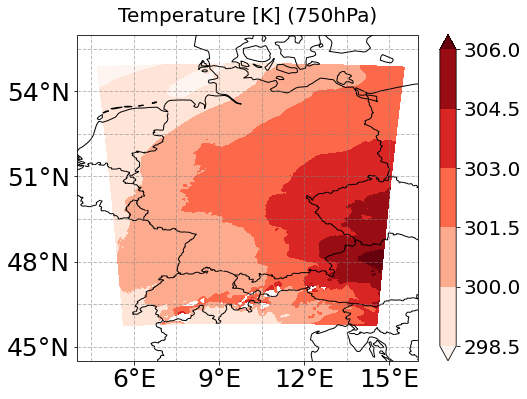

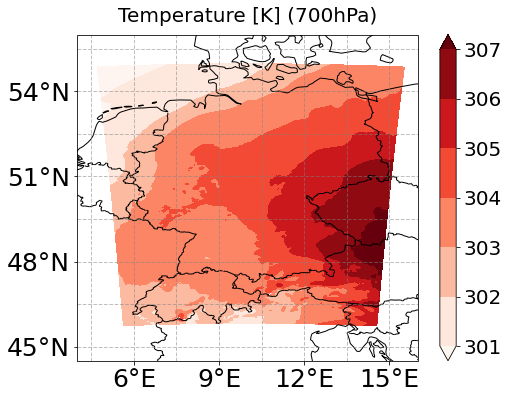

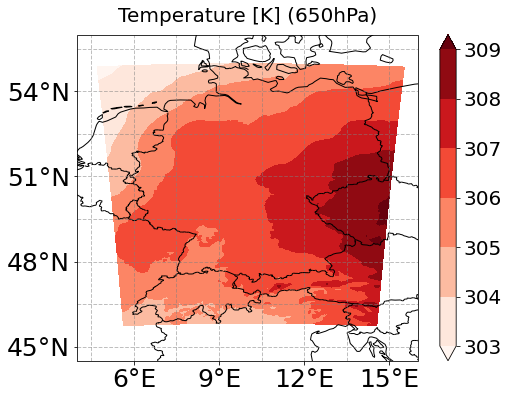

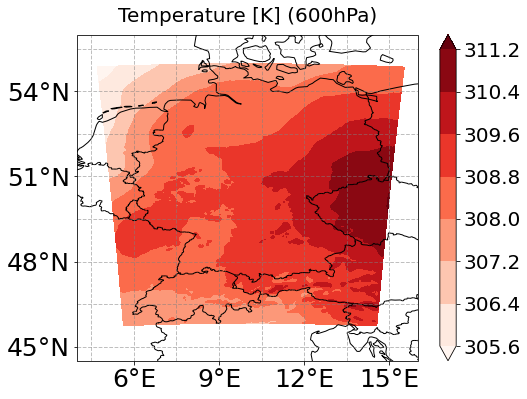

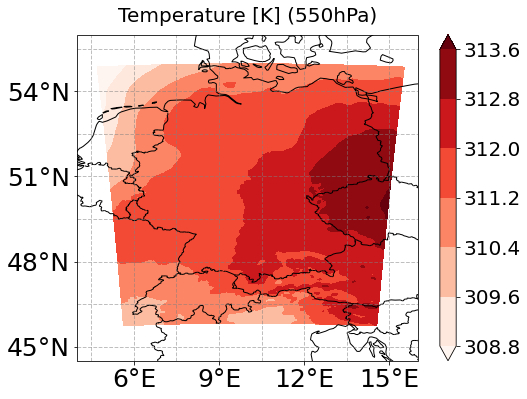

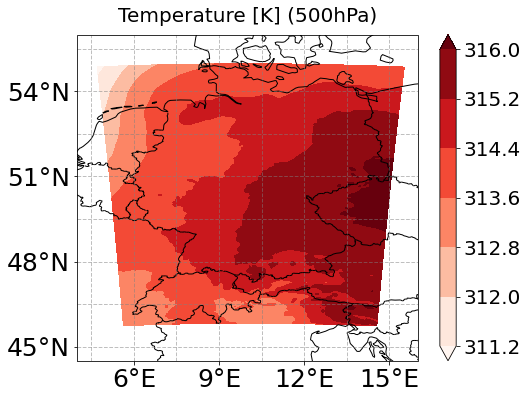

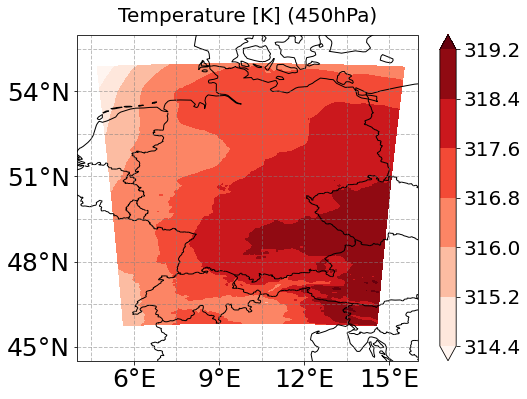

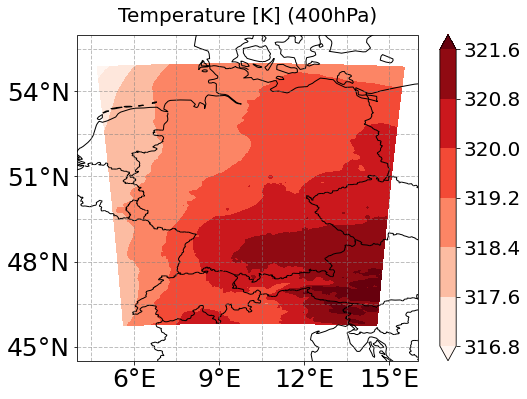

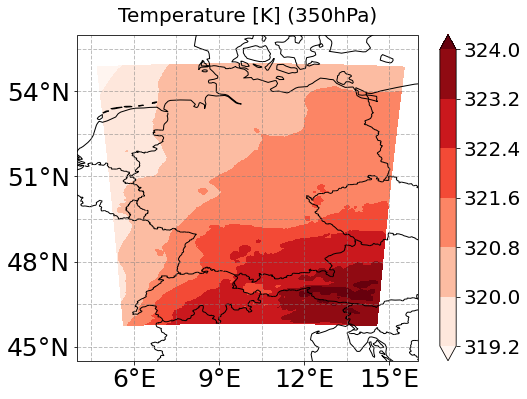

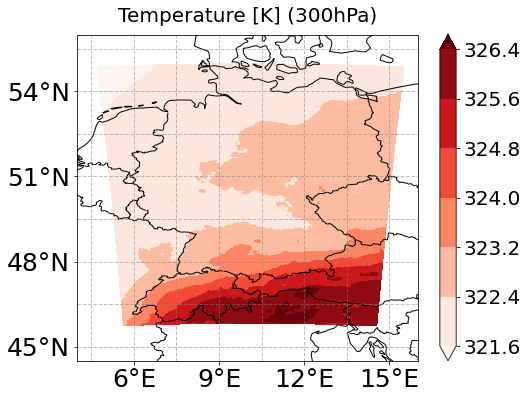

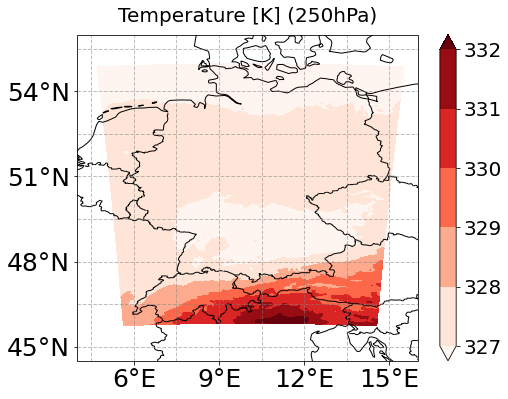

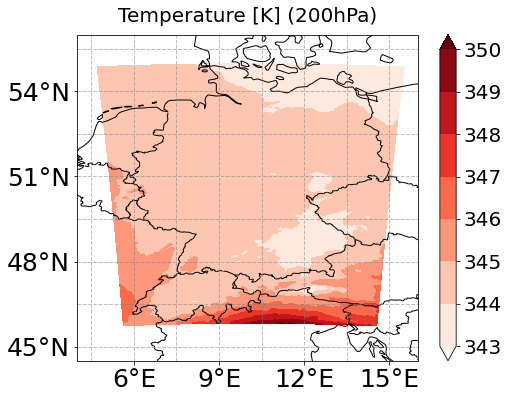

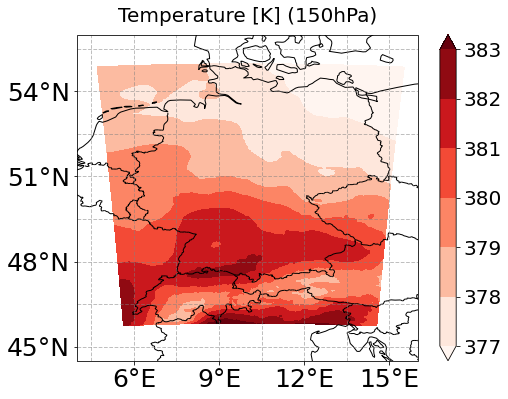

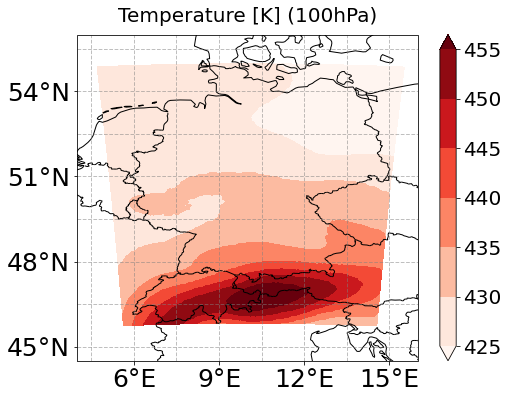

In [32]:
for i in range(20):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
    # Plot precipitaion with special colorbar
#     clevs = np.linspace(0,50,11)
    #colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
    plt.contourf(lon2d, lat2d,np.nanmean(theta_array[::,i,::,::],0),cmap='Reds',  extend='both', transform=crs.PlateCarree()) 
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)

    ax.set_title('Temperature [K] ('+ str(int(dataset_TH.coords['lev'].values[i])) +'hPa)', size =20,y=1.02)
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
    ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
    ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#     plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/theta_'+str(int(dataset.coords['lev'].values[i]))+'_'+ens+'mem_2016'+date+'1500.png')

## Plotting Stability

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

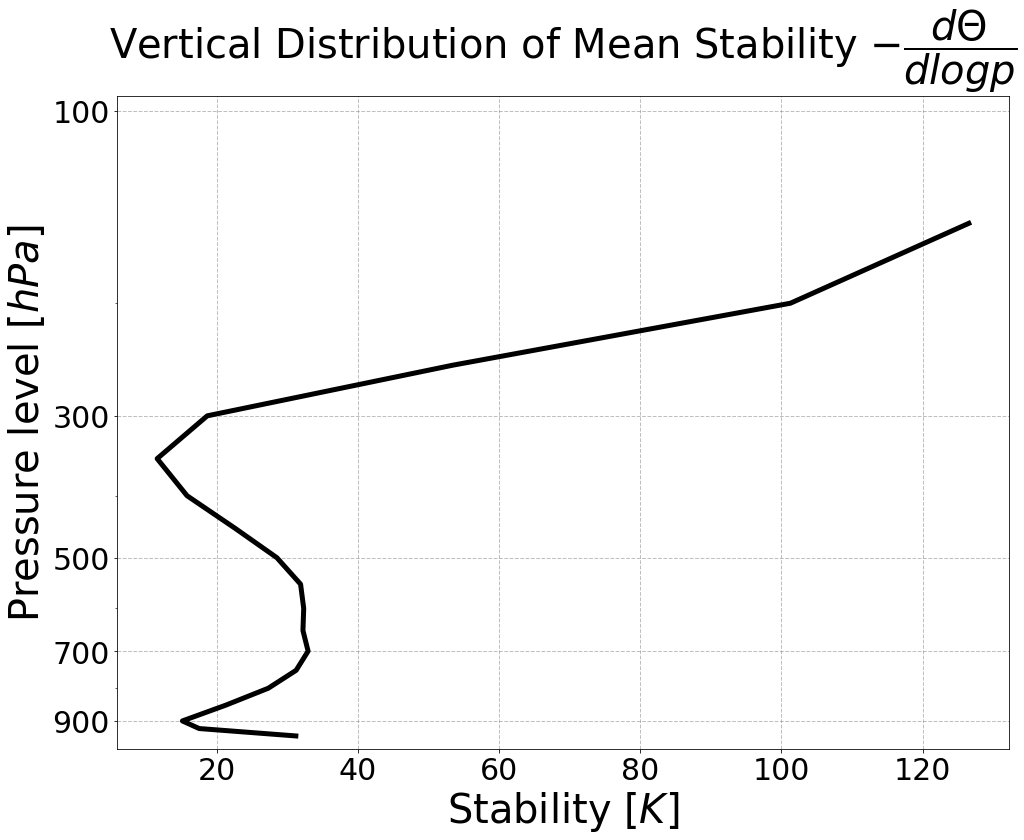

In [33]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(stab,(0,2,3)),dataset_TH.coords['lev'].values[1:19], linewidth = 5,c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('Vertical Distribution of Mean Stability $-\dfrac{d\Theta}{dlogp}$', size =40,y=1.05)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Stability [$K$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
# plt.xlim(-0.05e-5,2.1e-5)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_stability_vert_'+ens+'mem_2016'+date+'1500.png')

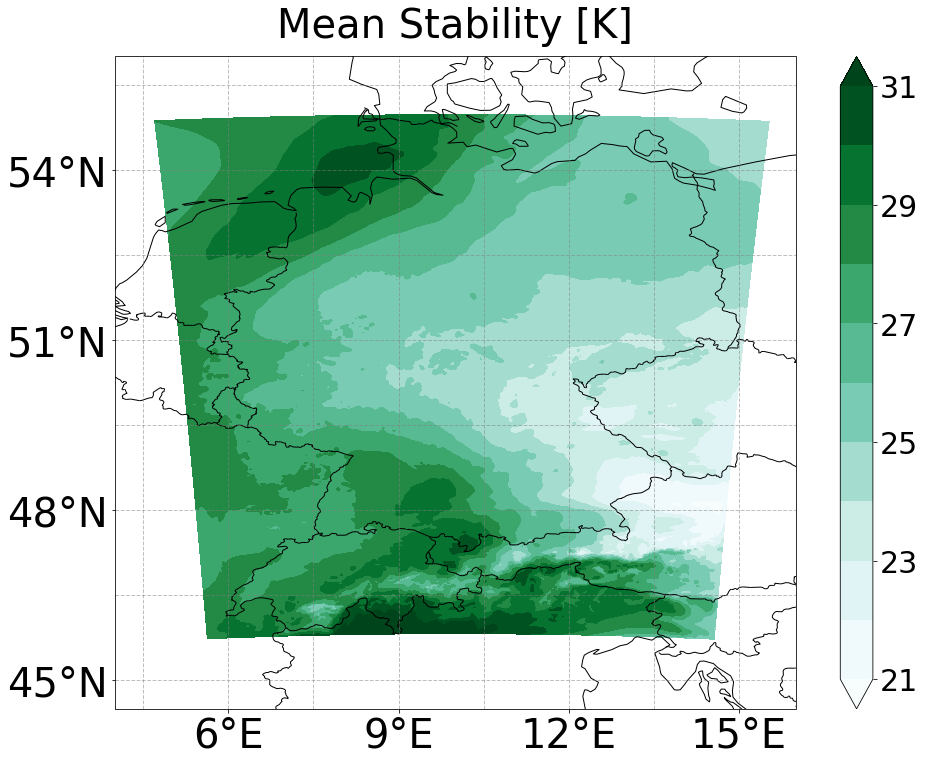

In [34]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
# Plot precipitaion with special colorbar
clevs = np.linspace(21,31,11)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,np.nanmean(stab[::,5:14],(0,1)),clevs,cmap='BuGn', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

ax.set_title('Mean Stability [K]', size =40,y=1.02)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_stability_'+ens+'mem_2016'+date+'1500.png')

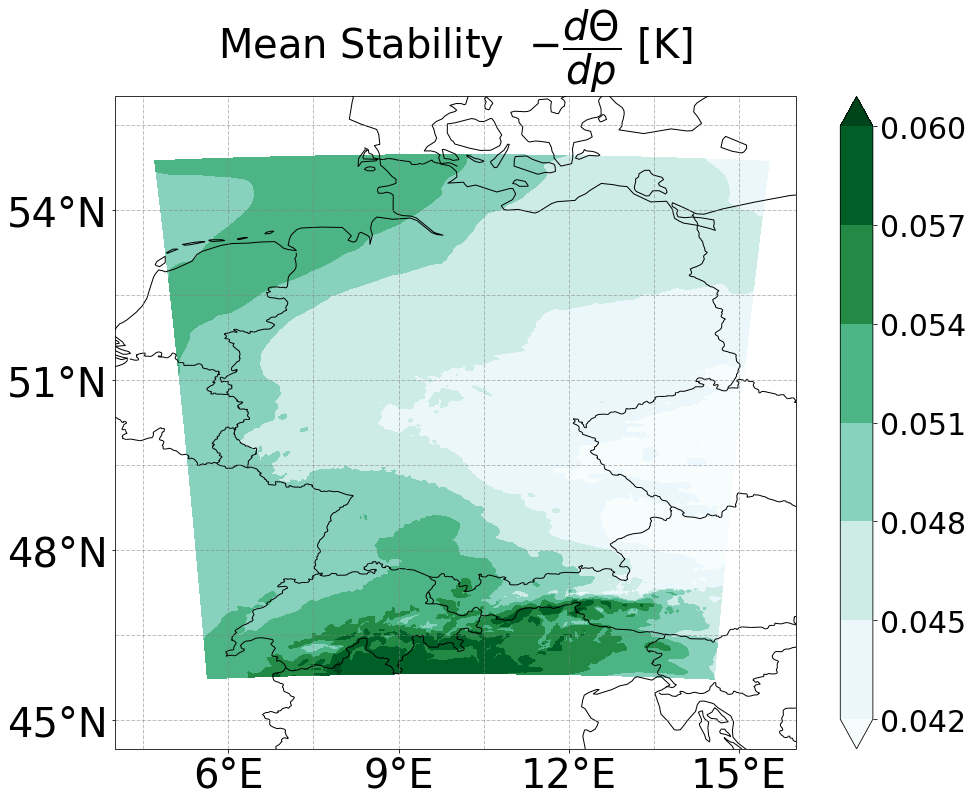

In [35]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
# Plot precipitaion with special colorbar
# clevs = np.linspace(0.04,0.06,11)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,np.nanmean(stab1[::,5:14],(0,1)),cmap='BuGn', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

ax.set_title('Mean Stability  $-\dfrac{d\Theta}{dp}$ [K]', size =40,y=1.05)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_p_'+ens+'mem_2016'+date+'1500.png')

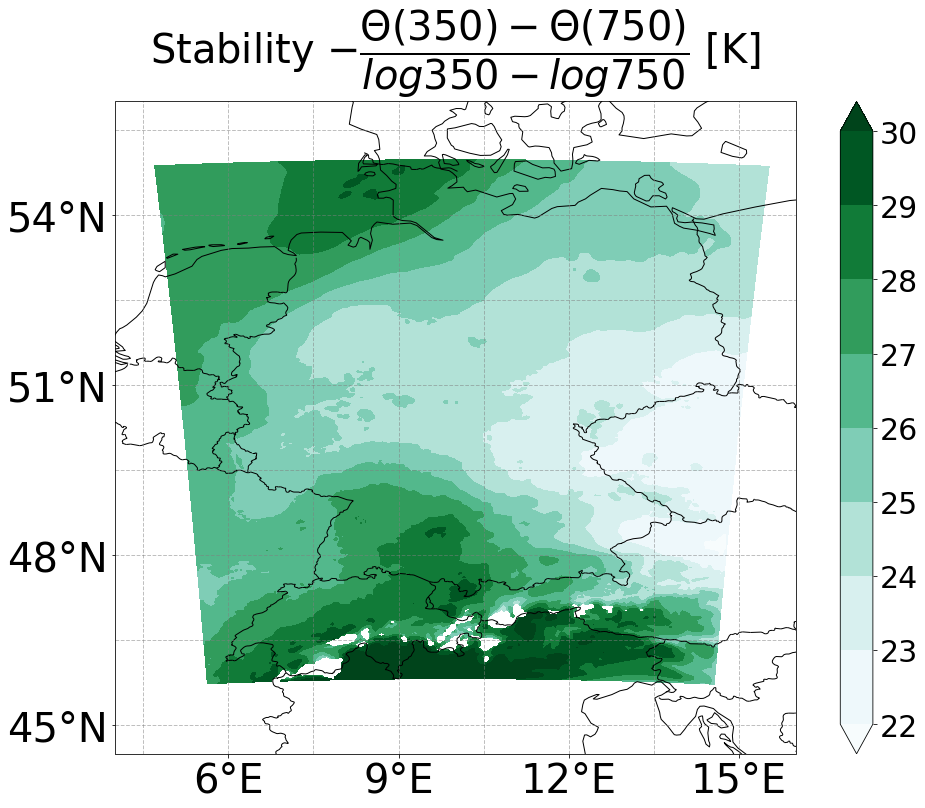

In [36]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
# Plot precipitaion with special colorbar
clevs = np.linspace(22,30,9)
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,np.nanmean(stab2,0),clevs,cmap='BuGn', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

ax.set_title('Stability $-\dfrac{\Theta(350)-\Theta(750)}{log350-log750}$ [K]', size =40,y=1.05)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_stability_two_levels_'+ens+'mem_2016'+date+'1500.png')

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

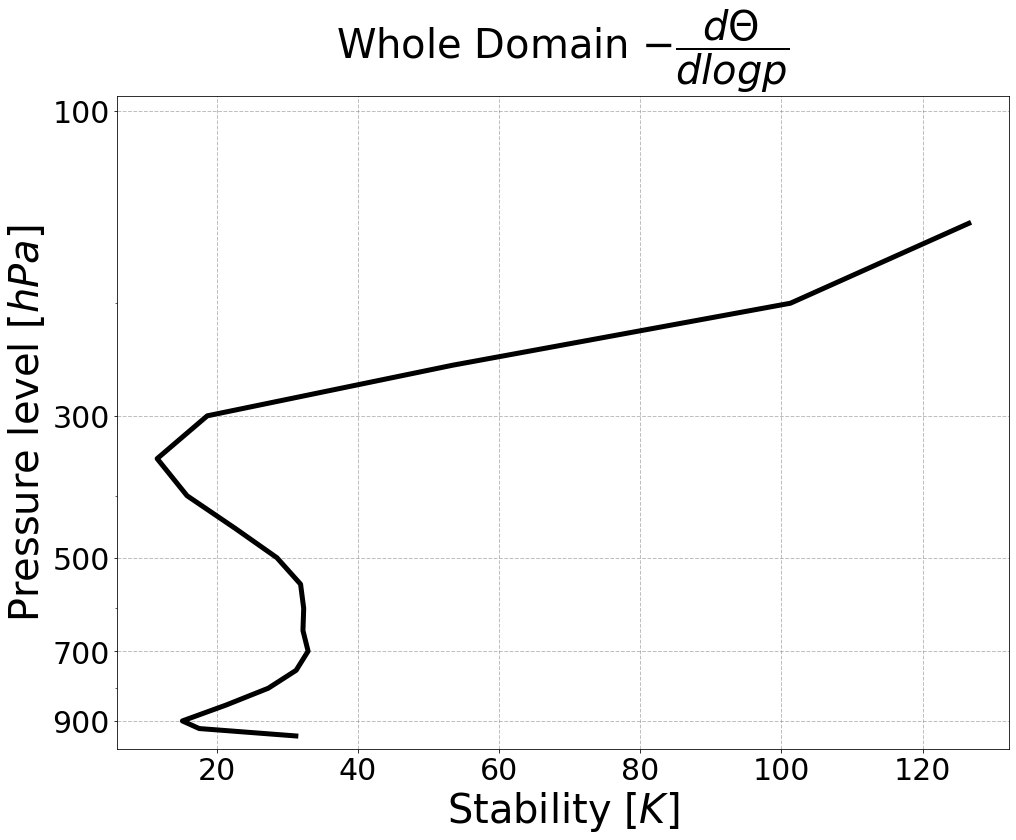

In [37]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(stab,(0,2,3)),dataset_TH.coords['lev'].values[1:19], linewidth = 5,c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('Whole Domain $-\dfrac{d\Theta}{dlogp}$', size =40,y=1.05)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Stability [$K$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
# plt.xlim(-0.05e-5,2.1e-5)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_vert_whole_log_'+ens+'mem_2016'+date+'1500.png')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

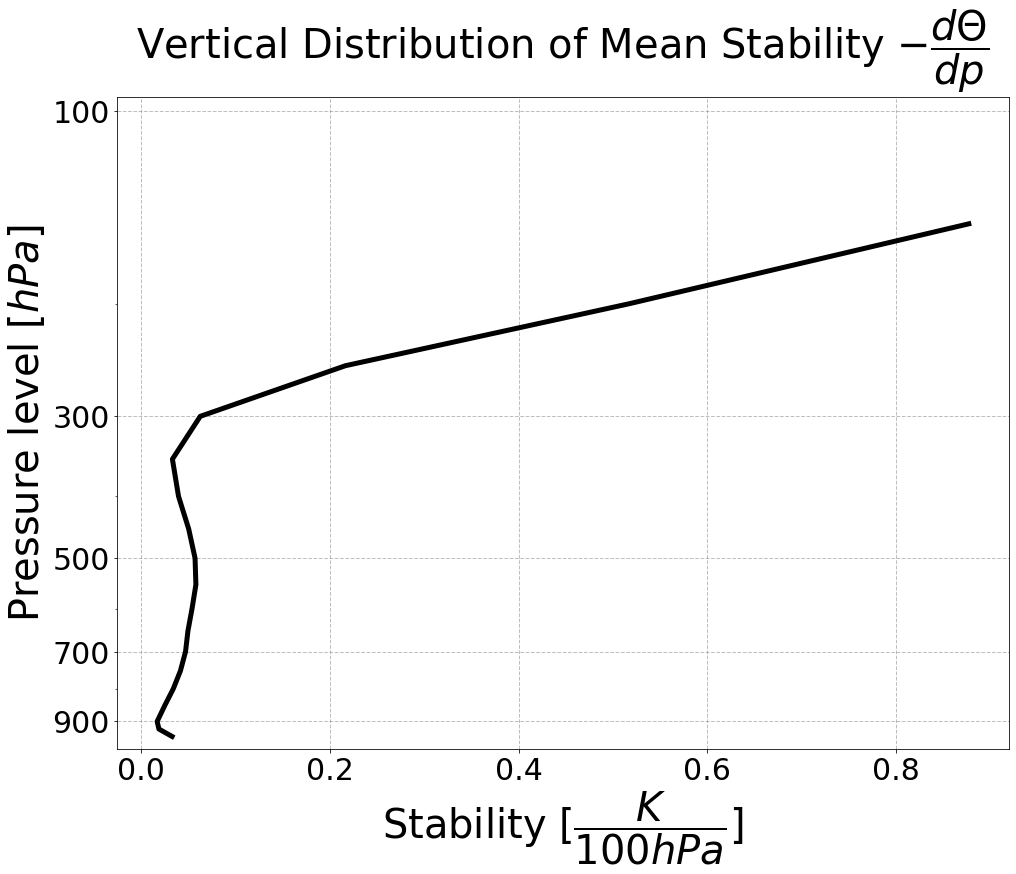

In [38]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(stab1,(0,2,3)),dataset_TH.coords['lev'].values[1:19], linewidth = 5, c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('Vertical Distribution of Mean Stability $-\dfrac{d\Theta}{dp}$', size =40,y=1.05)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Stability [$\dfrac{K}{100hPa}$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
# plt.xlim(-0.05e-5,2.1e-5)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_vert_whole_'+ens+'mem_2016'+date+'1500.png')

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

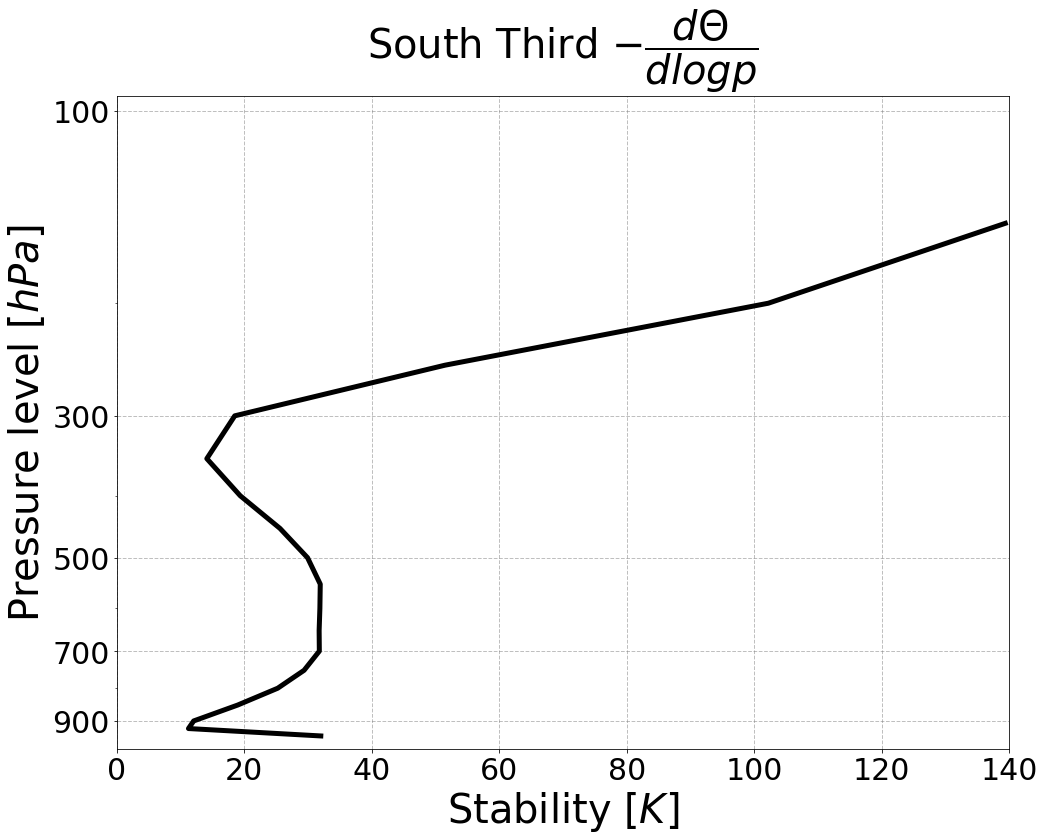

In [39]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(stab[::,::,:int(theta_array.shape[2]/3),::],(0,2,3)),dataset_TH.coords['lev'].values[1:19], linewidth = 5, c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('South Third $-\dfrac{d\Theta}{dlogp}$', size =40,y=1.05)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Stability [$K$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
plt.xlim(0,140)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_vert_south_'+ens+'mem_2016'+date+'1500.png')

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

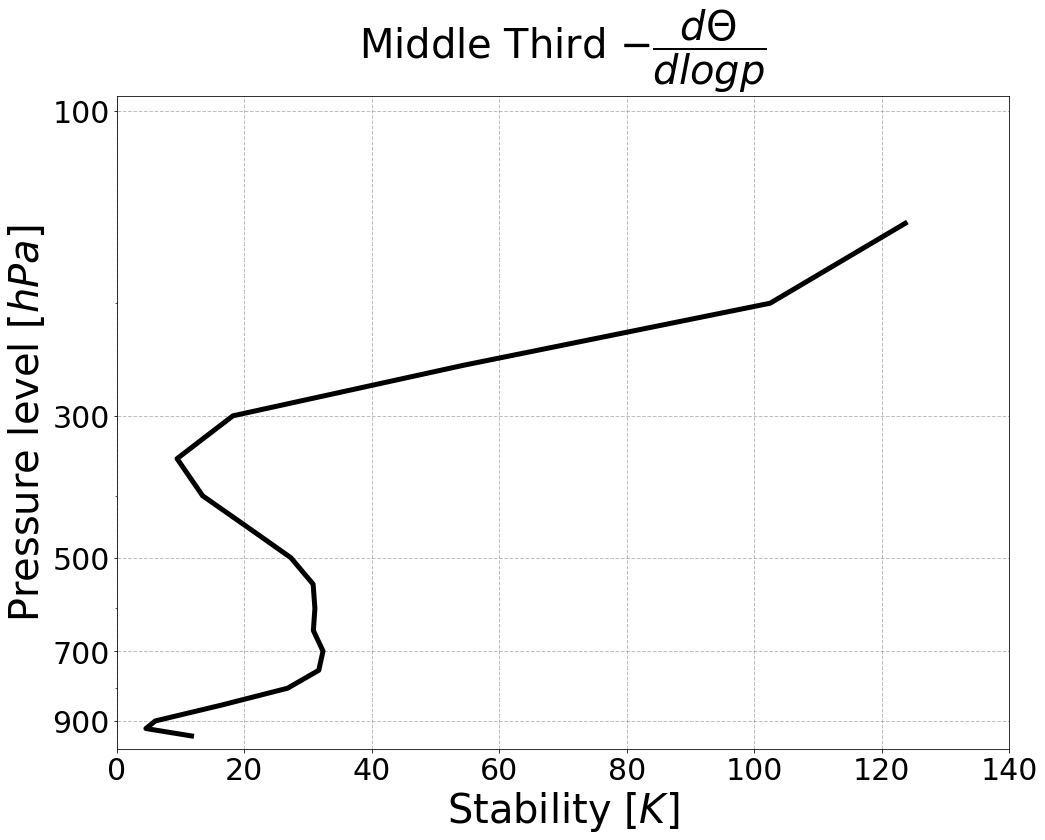

In [40]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(stab[::,::,int(theta_array.shape[2]/3):int(2*theta_array.shape[2]/3),::],(0,2,3)),dataset_TH.coords['lev'].values[1:19], linewidth = 5, c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('Middle Third $-\dfrac{d\Theta}{dlogp}$', size =40,y=1.05)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Stability [$K$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
plt.xlim(0,140)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_vert_middle_'+ens+'mem_2016'+date+'1500.png')

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

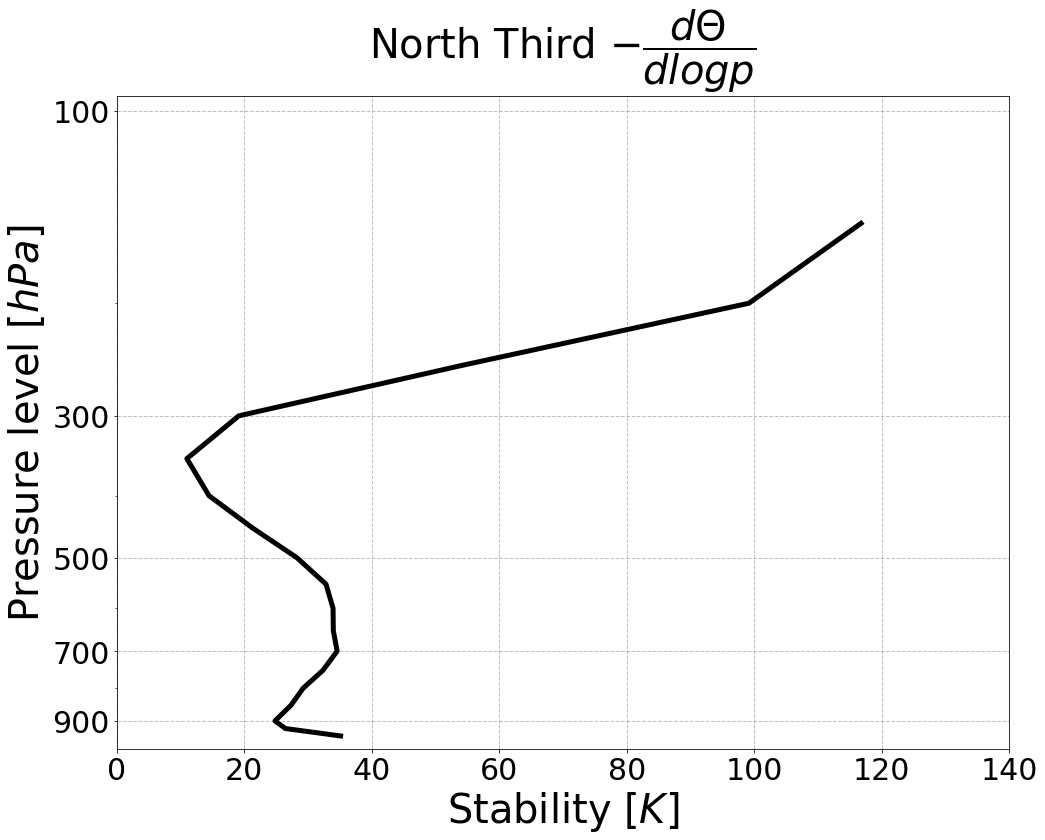

In [41]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1)

ax.plot(np.nanmean(stab[::,::,int(2*theta_array.shape[2]/3):theta_array.shape[2],::],(0,2,3)),dataset_TH.coords['lev'].values[1:19], linewidth = 5, c = 'k')

ax.set_yscale('log')
# plt.legend(fontsize = 30)
ax.invert_yaxis()
ax.set_title('North Third $-\dfrac{d\Theta}{dlogp}$', size =40,y=1.05)
ax.set_ylabel('Pressure level [$hPa$]',size = 40)
ax.set_xlabel('Stability [$K$]',size = 40)
ax.set_yticks(ticks=[100,300,500,700,900])
ax.set_yticklabels([100,300,500,700,900])
# ax.set_xticks(np.linspace(0,2,5)*1e-5)
plt.ylim(995,95)
plt.xlim(0,140)
ax.grid(linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax.xaxis.offsetText.set_fontsize(30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_vert_north_'+ens+'mem_2016'+date+'1500.png')

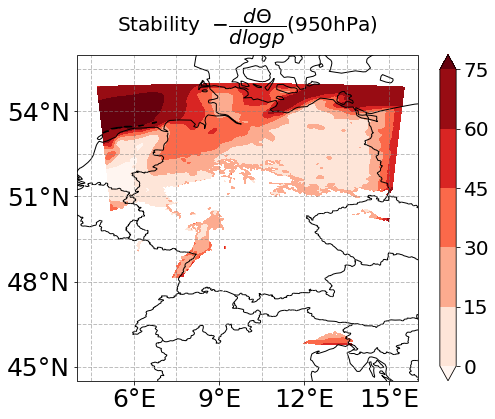

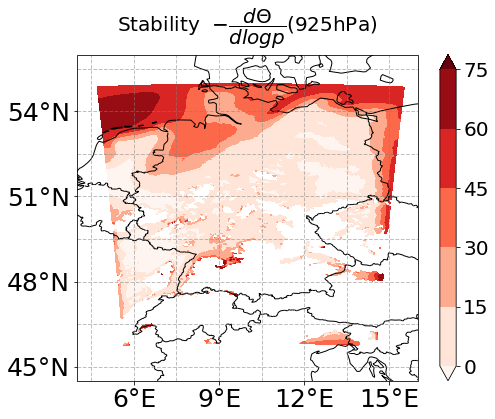

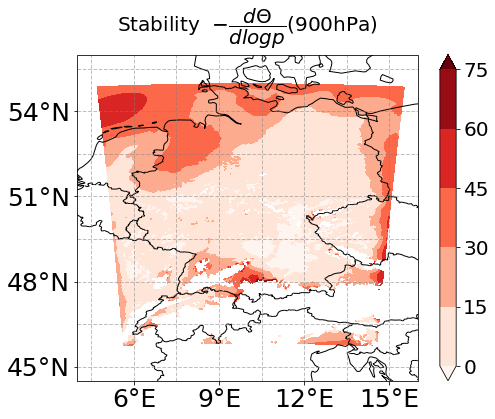

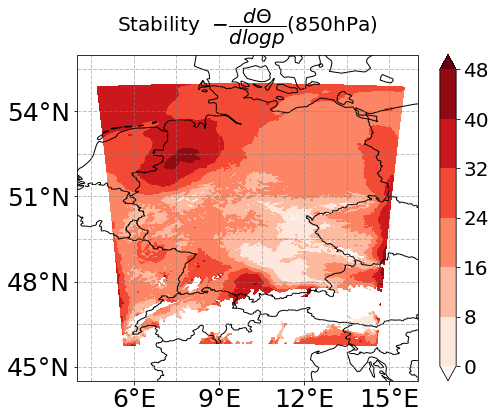

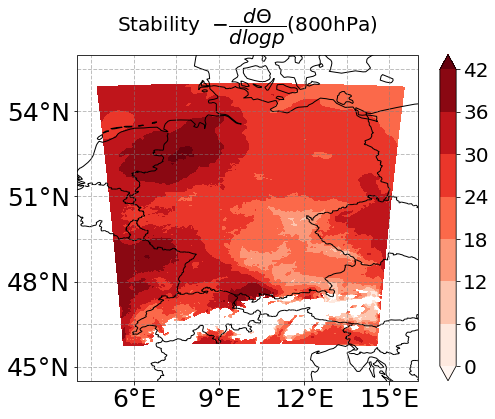

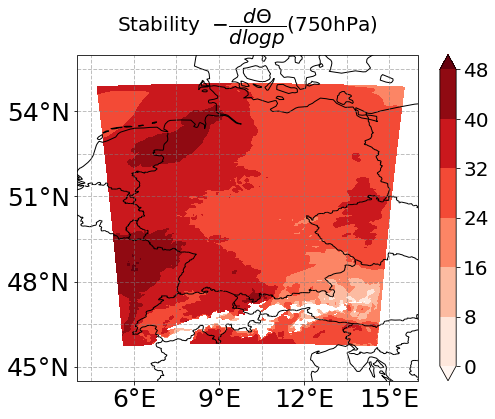

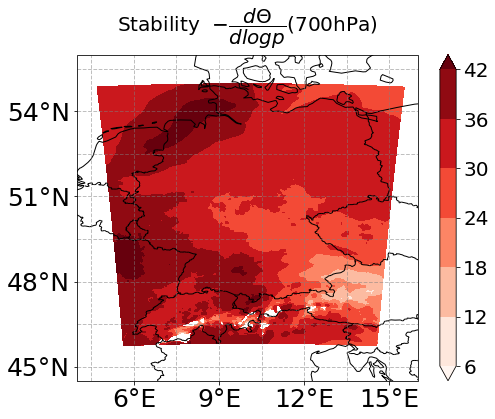

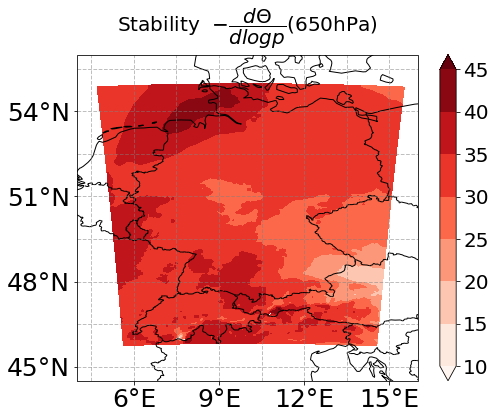

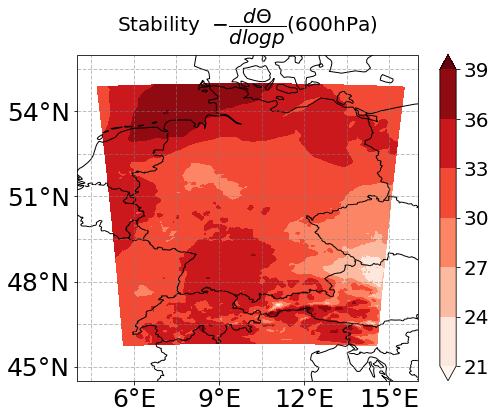

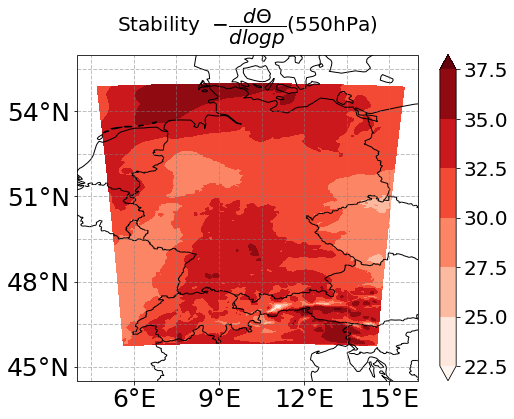

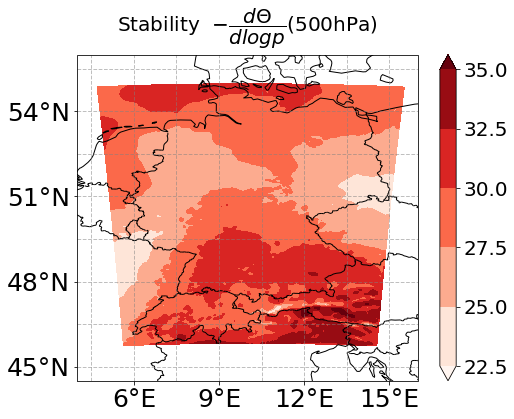

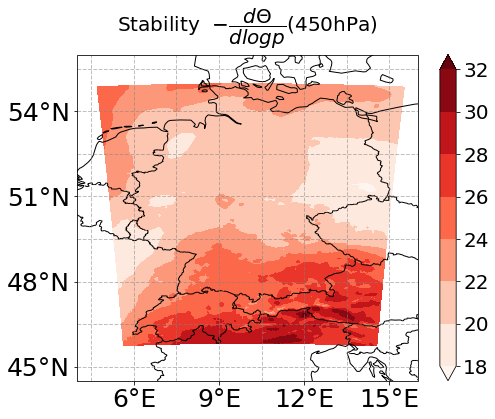

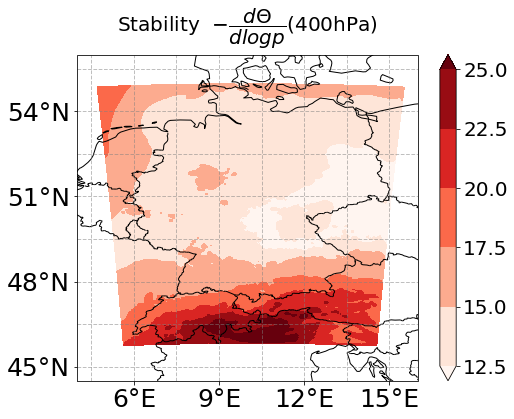

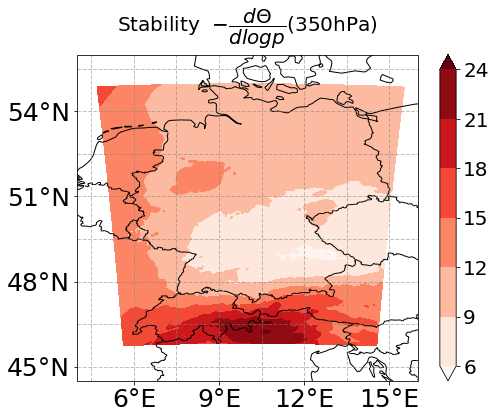

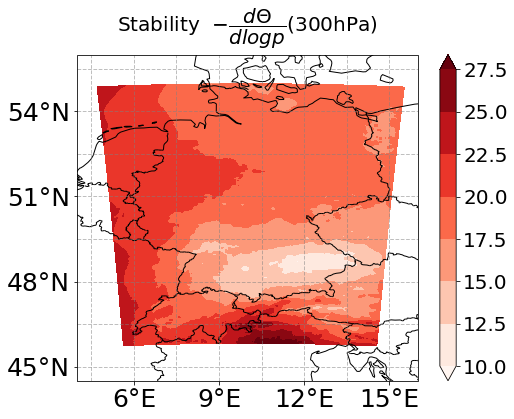

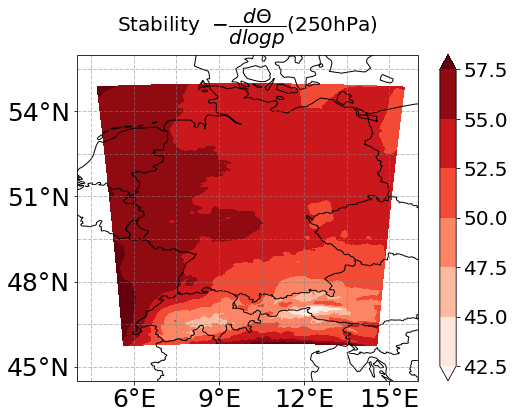

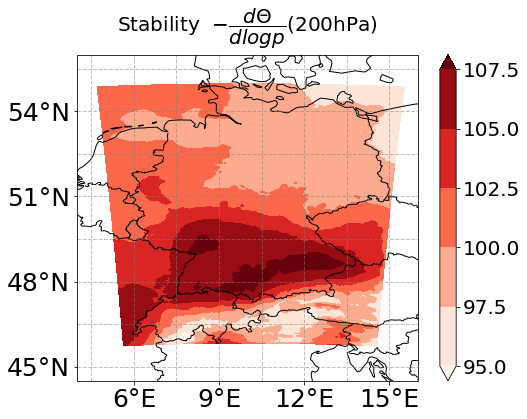

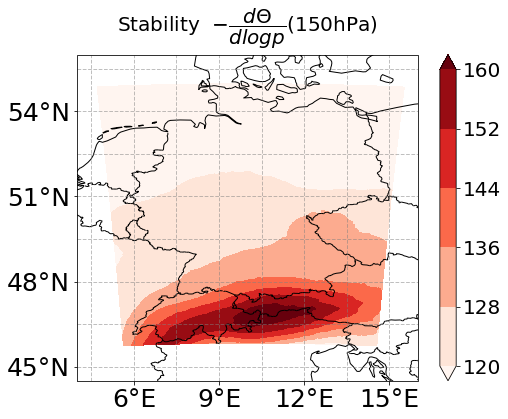

In [47]:
for i in range(18):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
    
    plt.contourf(lon2d, lat2d,np.nanmean(stab[::,i,::,::],0),cmap='Reds',  extend='both', transform=crs.PlateCarree()) 
    
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=20)

    ax.set_title('Stability  $-\dfrac{d\Theta}{dlogp}$('+ str(int(dataset_TH.coords['lev'].values[i+1])) +'hPa)', size =20,y=1.05)
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
    ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
    ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#     plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/stability_logp_'+str(int(dataset.coords['lev'].values[i+1]))+'_'+ens+'mem_2016'+date+'1500.png')

## Plotting Precipitation

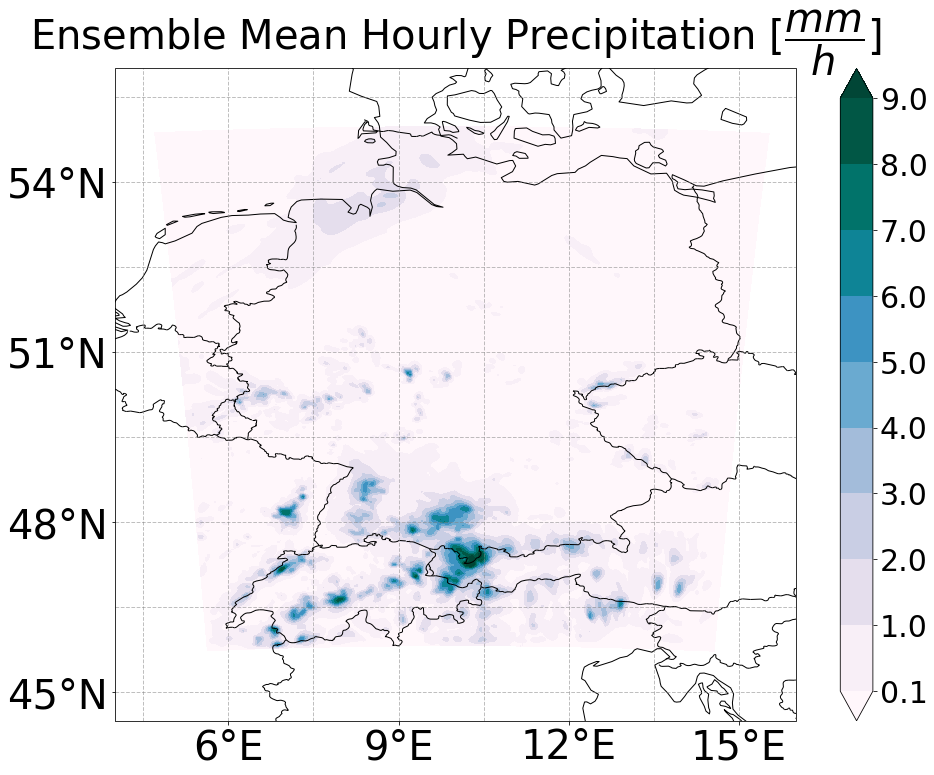

In [49]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.array([ 0.1, 1 , 2, 3, 4, 5, 6, 7, 8, 9])
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,np.mean(prec,axis=0)*3600,clevs,cmap='PuBuGn', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Ensemble Mean Hourly Precipitation [$\dfrac{mm}{h}$]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_mean_prec_'+ens+'mem_2016'+date+'1500.png')

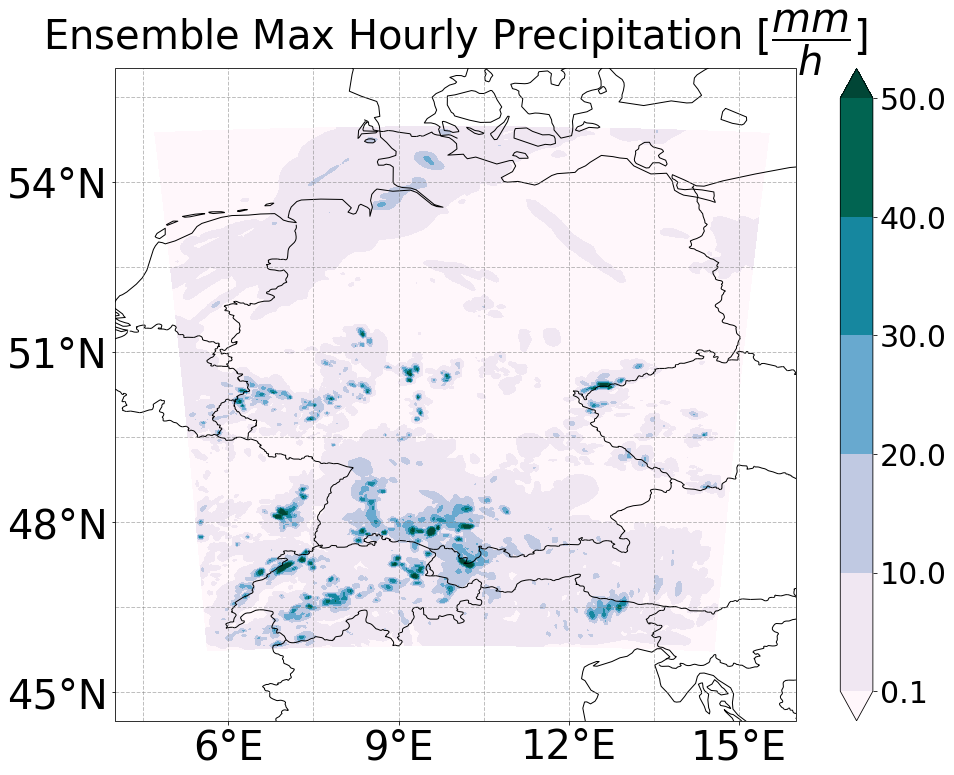

In [52]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# Plot precipitaion with special colorbar
clevs = np.array([ 0.1, 10 , 20, 30, 40, 50])
#colors = ("#ffffff","#F0EABB","#C0E69F","#72E1A2","#00D8BC","#00C7DC","#00AAF2","#847CF2","#BA3CD0","#B40087")
plt.contourf(lon2d, lat2d,prec_max*3600,clevs,cmap='PuBuGn', extend='both', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Ensemble Max Hourly Precipitation [$\dfrac{mm}{h}$]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_max_prec_'+ens+'mem_2016'+date+'1500.png')

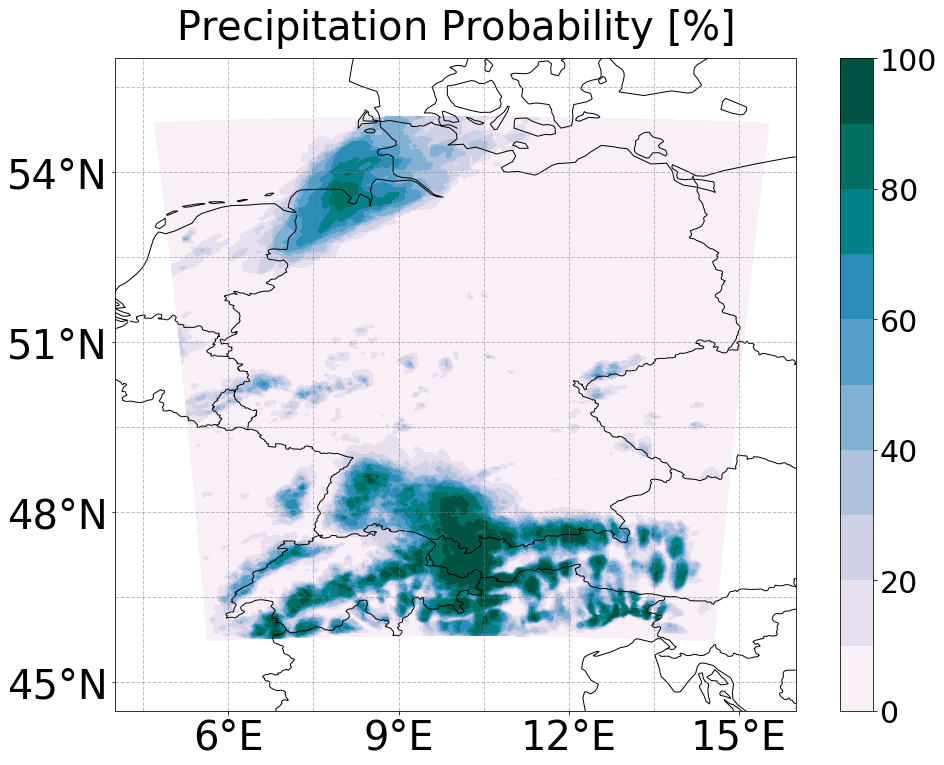

In [55]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

clevs = np.linspace(0,100,11)
# colors = ("#ffffff",'#0000FF')
plt.contourf(lon2d, lat2d,prec_prob*100,clevs,cmap = 'PuBuGn', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
# cb.ax.set_yticklabels(['','  Low \n ($\leq 2$)', ' Medium \n ($2-10$)', '  High \n ($\geq 10$)'])

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Precipitation Probability [$\%$]', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_prec_prob_'+ens+'mem_2016'+date+'1500.png')

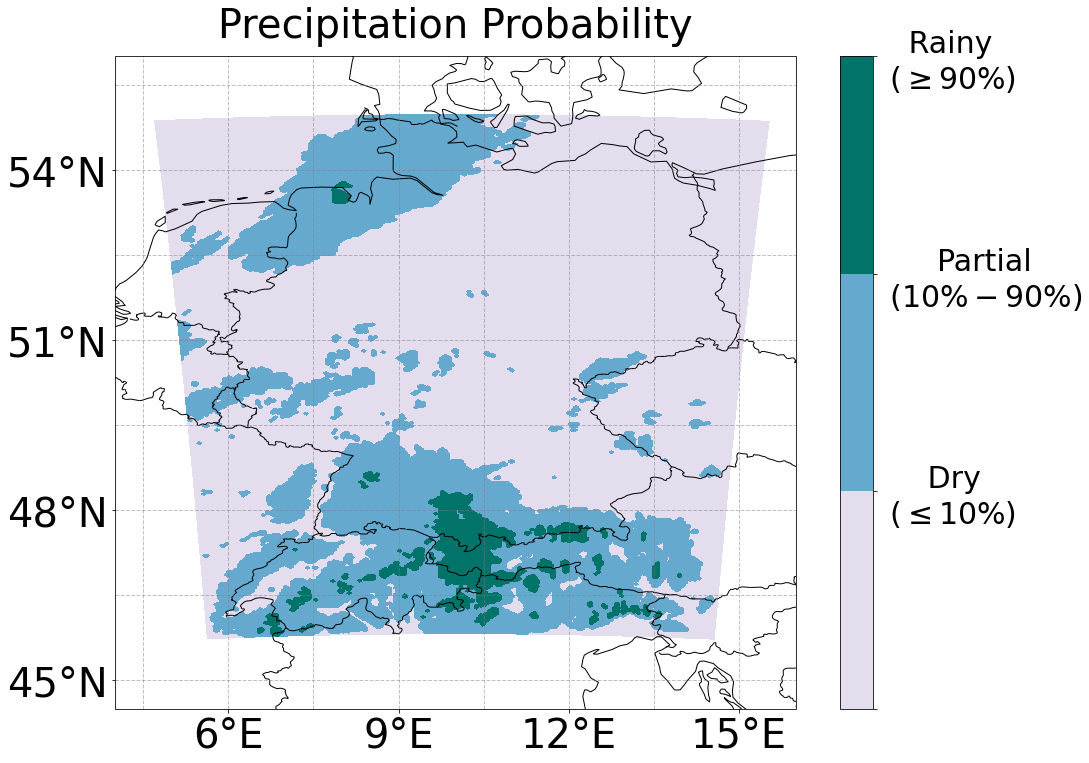

In [56]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

clevs = [0,1,2,3]
# colors = ("#ffffff",'#0000FF')
plt.contourf(lon2d, lat2d,prec_prob_low+prec_prob_medi+prec_prob_high,clevs,cmap = 'PuBuGn', extend='neither', transform=crs.PlateCarree()) 
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
cb.ax.set_yticklabels(['','     Dry \n ($\leq 10\%$)', '      Partial \n ($10\% - 90\%$)', '   Rainy \n ($\geq 90\%$)'])

# Customize fig, axis and labels
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.set_extent([4, 16, 44.5, 56], crs=crs.PlateCarree())
ax.gridlines(draw_labels=False, x_inline=False, y_inline=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xticks(ticks=[6, 9, 12, 15], crs=crs.PlateCarree())
ax.set_yticks(ticks=[45, 48, 51, 54], crs=crs.PlateCarree())
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
ax.set_title('Precipitation Probability', size =40,y=1.02)
# ax.text(4,43.3,day+'. '+m+' 2016 '+t+' UTC             '+ens+' member ensemble', size =25)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# plt.savefig(fname = '/mnt/students/a11920130/Bachelor/Plots_1000_member/new_class_prec_prob_'+ens+'mem_2016'+date+'1500.png')